In [0]:
# choose TF version
%tensorflow_version 1.x

# select SNR of images 
training_snr = 0.4

# scaling for image position
posScale = 100

# import
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# load MNIST data (numpy arrays representing digit image)
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = tf.keras.datasets.mnist.load_data()

# define image and labe creation function to be used by model.fit_generator.
# this function adds an MNIST digit (28x28) to a noisy image.
# the label includes the digit class (0-9) and the x-y position of the digit in the image.
class DataGenerator(tf.keras.utils.Sequence):
  # constructor changes (compared to inherited constructor)
  def __init__(self, snr):
    self.snr = snr

  # number of batches in an epoch
  def __len__(self):
    return 50
  
  # batch creation (images and labels)
  def __getitem__(self,index):
      # batch size
      batchSize = 128
      
      # choose noise level
      noise_intensity = 10.0
      snrLevel = self.snr;
      facSignal = np.array([snrLevel*noise_intensity/255.0])
      
      # random indices of samples from MNIST
      idxTrain = np.floor( 59999*np.random.rand(batchSize,1) ).astype(int)
      
      # create larger 128x128 canvases, that will be the input layer
      xtrain = noise_intensity*np.random.rand(batchSize,128,128) 
      
      # create random positions
      posx_train = np.floor( 99.0*np.random.rand(batchSize,1) ).astype(int)
      posy_train = np.floor( 99.0*np.random.rand(batchSize,1) ).astype(int)
      
      # create labels for train data
      ytrain = np.zeros((batchSize,12)) # one hot encoding and x-y position
      ytrain[:,10] = posx_train[:,0]/posScale
      ytrain[:,11] = posy_train[:,0]/posScale
      
      # embed numbers in canvas - train data
      ii = 0
      for idx0 in idxTrain:
        # randomize SNR for each image
        snrLevel = self.snr + 3*np.random.rand(1,1);
        facSignal = np.array([snrLevel*noise_intensity/255.0])

        idx = idx0.item()
        i0 = posx_train[ii].item()
        i1 = i0 + 28
        j0 = posy_train[ii].item()
        j1 = j0 + 28
        xtrain[ii,i0:i1,j0:j1] = xtrain[ii,i0:i1,j0:j1] + x_train_mnist[idx]*facSignal
        # normalization
        #xtrain = xtrain / (facSignal*255 + noise_intensity)        
        ytrain[ii, y_train_mnist[idx] ] = 1.0 # one hot encoding 
        ii = ii + 1

      # reshape images (add dimension)
      xtrain = xtrain.reshape(xtrain.shape[0], 128, 128, 1)/(255*facSignal + noise_intensity)

      # return results
      return xtrain, [ytrain[:,0:10],ytrain[:,10:12]]
      
      #return xtrain, ytrain[:,10:12]

# create batch for debugging purposes
batchCreator = DataGenerator(training_snr)
X, Y = batchCreator.__getitem__(0)


11493376/11490434 [==============================] - 0s 0us/step


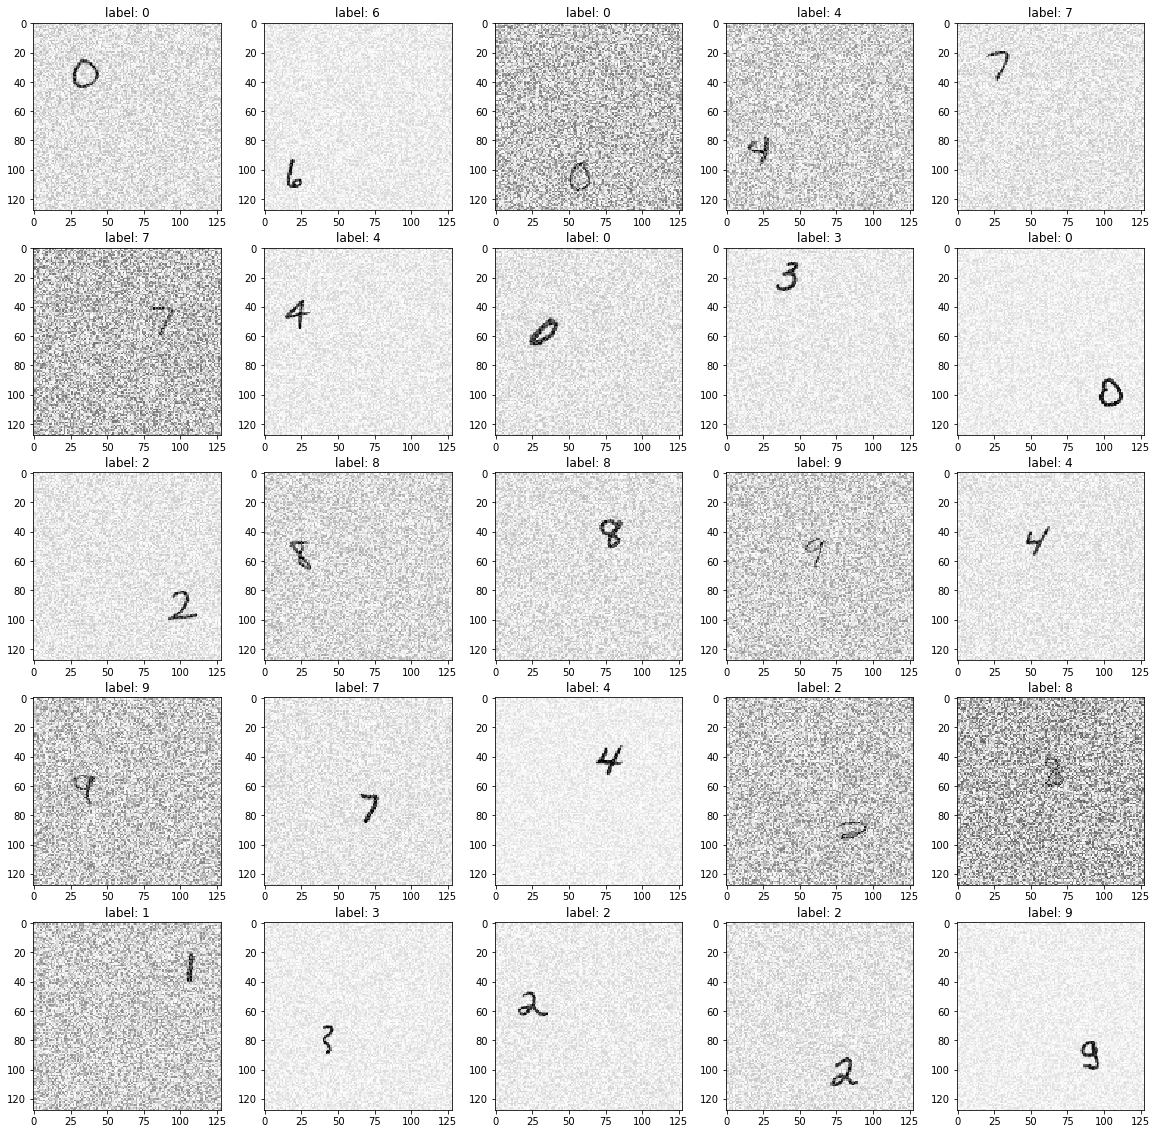

In [0]:
# plot sample
fig, axes = plt.subplots( 5, 5, figsize=(20,20) )
im = 0
for i in range(5):
  for j in range(5):
    # plot image and predicted label
    axes[ i, j ].imshow(X[im,:,:,0], cmap='Greys')
    axes[ i, j ].set_title('label: '+str(np.argmax(Y[0][im])) )

    # add predicted position
    #rect = patches.Rectangle((Y[1][im,1]*posScale,Y[1][im,0]*posScale),28,28,linewidth=1,edgecolor='r',facecolor='none')
    #axes[ i, j ].add_patch(rect)

    # propagate image number
    im += 1

plt.show()

In [0]:
# create a keras neural network model

from keras.models import Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Multiply, Input, LeakyReLU, Concatenate,concatenate
from keras import backend as K 

#k_constants = K.variable([[10,128,128]]) 
#ones_tensor = Input(tensor=k_constants)

my_input_shape = (128, 128, 1)

# input layer
xlayer = Input(shape=my_input_shape)

# layers for both nns:
internallayer = Conv2D(16, kernel_size=(5,5), input_shape=my_input_shape, strides=1, padding='valid')(xlayer) 
internallayer = LeakyReLU(alpha=0.1)(internallayer)
internallayer = MaxPooling2D(pool_size=2)(internallayer) # output 2 breaks off here


# only for output2 (position of digit):
internallayer2 = Conv2D(4, kernel_size=(5,5), input_shape=my_input_shape, strides=1, padding='valid')(internallayer)
internallayer2 = LeakyReLU(alpha=0.1)(internallayer2)
internallayer2 = MaxPooling2D(pool_size=2)(internallayer2)
internallayer2 = Conv2D(4, kernel_size=(5,5), strides=1, padding='valid')(internallayer2)
internallayer2 = LeakyReLU(alpha=0.1)(internallayer2)
internallayer2 = MaxPooling2D(pool_size=2)(internallayer2)
internallayer_f2 = Flatten()(internallayer2)
outlayer2 = Dense(2,activation=tf.nn.sigmoid)(internallayer_f2) # output2 (digit position in x and y)

# only for output 1 (type of digit):
internallayer1 = Conv2D(8, kernel_size=(5,5), strides=1, padding='valid')(internallayer)
internallayer1 = LeakyReLU(alpha=0.1)(internallayer1)
internallayer1 = MaxPooling2D(pool_size=2)(internallayer1)
internallayer1 = Conv2D(8, kernel_size=(5,5), strides=1, padding='valid')(internallayer1)
internallayer1 = LeakyReLU(alpha=0.1)(internallayer1)
internallayer1 = MaxPooling2D(pool_size=2)(internallayer1)
internallayer1 = Conv2D(8, kernel_size=(5,5), strides=1, padding='valid')(internallayer1)
internallayer1 = LeakyReLU(alpha=0.1)(internallayer1)
internallayer1 = MaxPooling2D(pool_size=2)(internallayer1)
internallayer_f1 = Flatten()(internallayer1)
concatlayer = concatenate([internallayer_f1, outlayer2],axis=1)
outlayer1 = Dense(10,activation=tf.nn.softmax)(concatlayer) # output 1 (digit type one-hot encoding)


# model
model = Model(inputs=xlayer, outputs=[outlayer1,outlayer2])

# summary of model
print(model.summary())

# compile model  #loss='mean_absolute_error', 
model.compile(optimizer='adam', 
              loss=['categorical_crossentropy','mean_squared_error'],
              metrics=['accuracy'])


Epoch 1/200
50/50 [==============================] - 3s 57ms/step - loss: 2.3803 - dense_16_loss: 2.3041 - dense_15_loss: 0.0762 - dense_16_acc: 0.0992 - dense_15_acc: 0.5853
Epoch 2/200
50/50 [==============================] - 2s 32ms/step - loss: 2.3339 - dense_16_loss: 2.3034 - dense_15_loss: 0.0305 - dense_16_acc: 0.1011 - dense_15_acc: 0.8516
Epoch 3/200
50/50 [==============================] - 2s 34ms/step - loss: 2.3259 - dense_16_loss: 2.3026 - dense_15_loss: 0.0234 - dense_16_acc: 0.1022 - dense_15_acc: 0.8861
Epoch 4/200
50/50 [==============================] - 2s 33ms/step - loss: 2.3176 - dense_16_loss: 2.2949 - dense_15_loss: 0.0228 - dense_16_acc: 0.1144 - dense_15_acc: 0.8811
Epoch 5/200
50/50 [==============================] - 2s 35ms/step - loss: 2.2762 - dense_16_loss: 2.2561 - dense_15_loss: 0.0201 - dense_16_acc: 0.1313 - dense_15_acc: 0.8912
Epoch 6/200
50/50 [==============================] - 2s 33ms/step - loss: 2.1941 - dense_16_loss: 2.1768 - dense_15_loss: 0.0

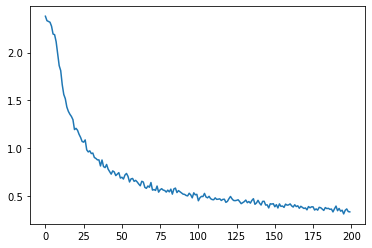

In [0]:
# train or load the neural network while creating the database at the same time

trainFlag = 1 # 0 = no trainig, load existing model

if trainFlag == 1:
  batchCreationMethod = DataGenerator(training_snr)
  history = model.fit_generator(batchCreationMethod, epochs=200)

  model.save('modelFindDigitNoisy_type2_lean.h5')  # creates a HDF5 file 

  # plot training result
  plt.plot(history.history['loss'])
  #plt.plot(history.history['acc'])

else:
  # returns a compiled model
  from keras.models import load_model
  #model = load_model('modelFindDigitNoisy.h5')
  model = load_model('modelFindDigitNoisy_type2.h5')

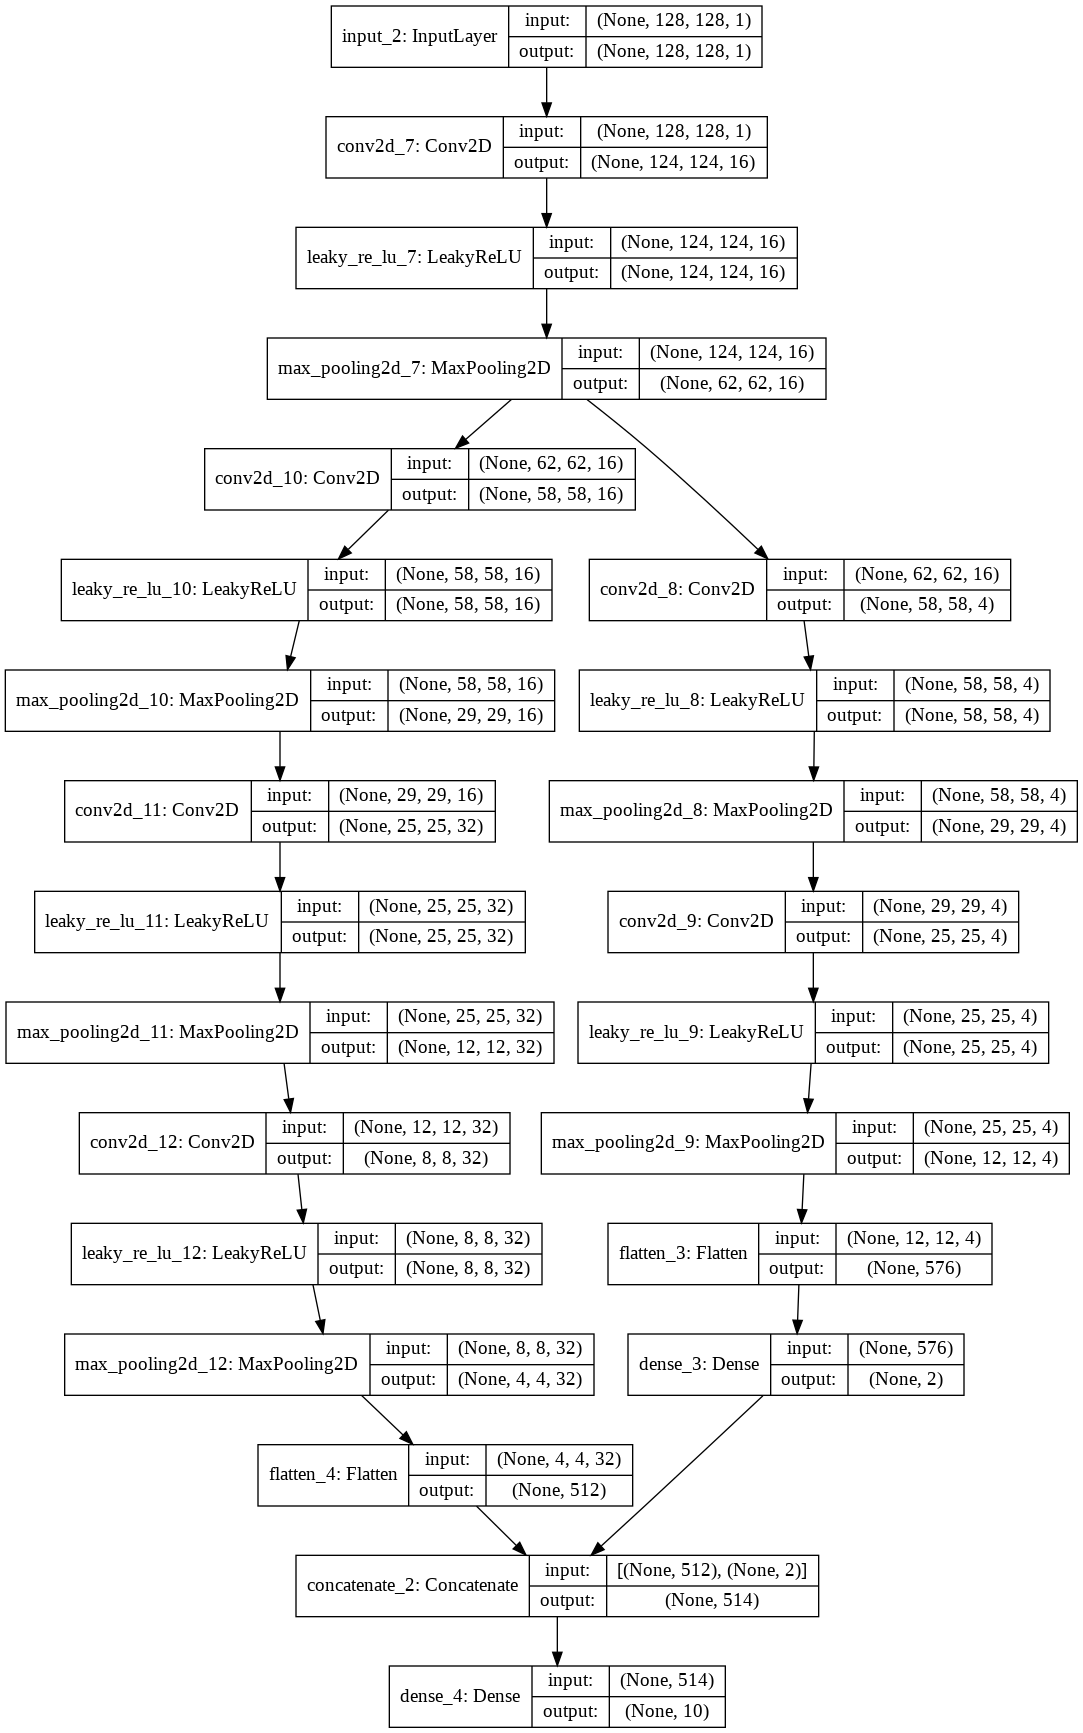

In [0]:
# create image of model
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)


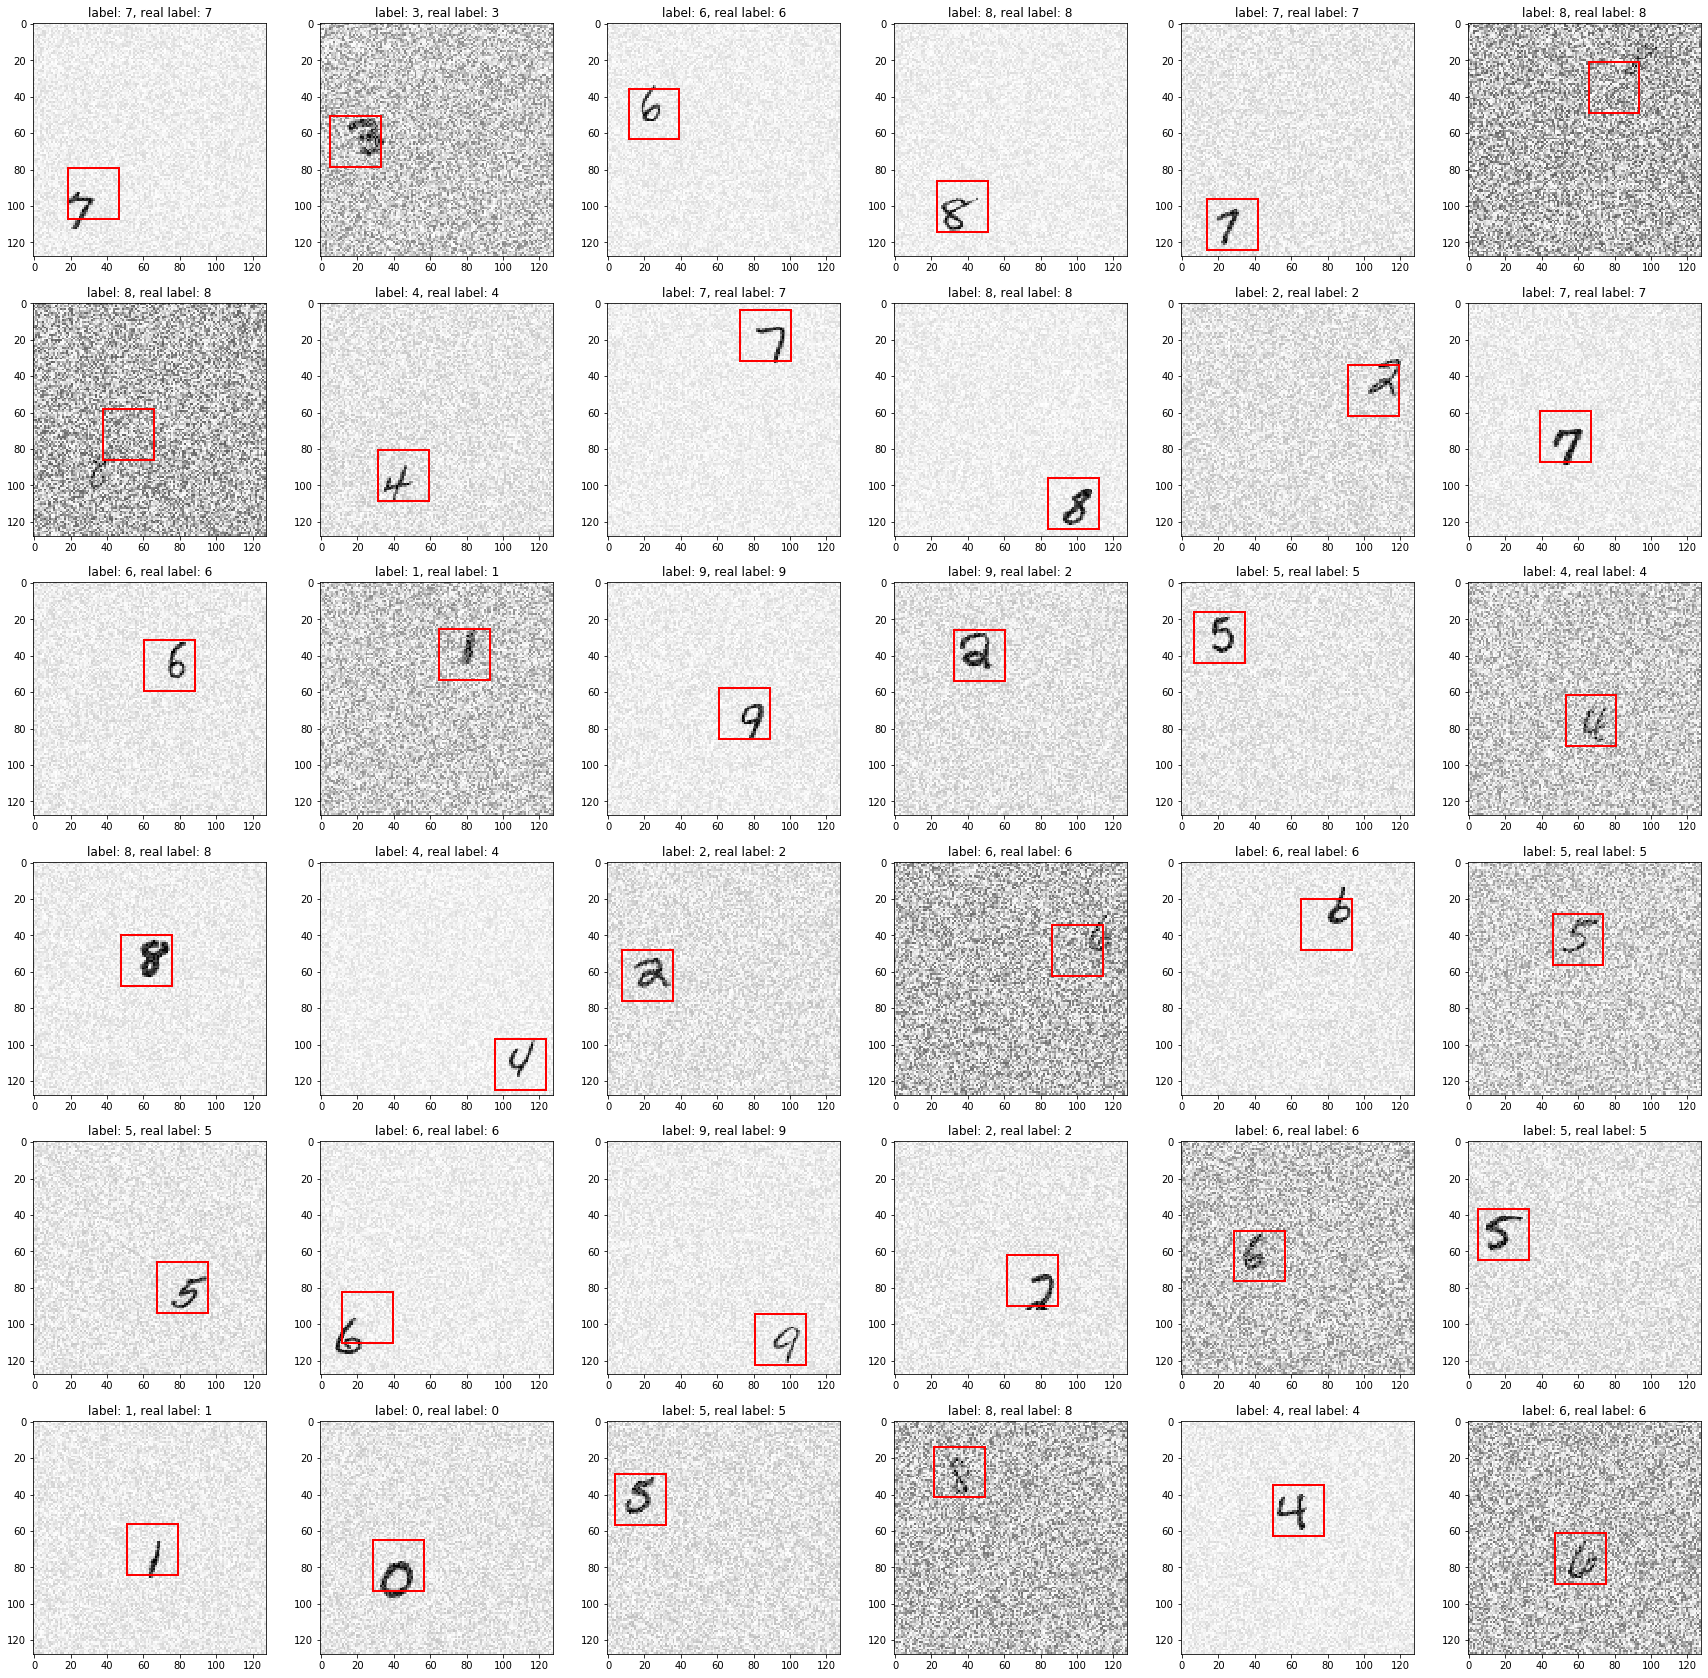

In [0]:
import matplotlib.patches as patches

# create batch for nn prediction testing
batchCreator = DataGenerator(training_snr)
X1, Y1 = batchCreator.__getitem__(0)


# prediction
pred_out = model.predict(X1[:,:,:,:])


# plot nn prediction sample
fig, axes = plt.subplots( 6, 6, figsize=(30,30) )
im = 0
for i in range(6):
  for j in range(6):
    # plot image and predicted label
    axes[ i, j ].imshow(X1[im,:,:,0], cmap='Greys')
    axes[ i, j ].set_title('label: '+str(np.argmax(pred_out[0][im])) + ', real label: '+str(np.argmax(Y1[0][im])) )

    # add predicted position
    rect = patches.Rectangle((pred_out[1][im,1]*posScale,pred_out[1][im,0]*posScale),28,28,linewidth=2,edgecolor='r',facecolor='none')
    axes[ i, j ].add_patch(rect)

    # propagate image number
    im += 1

plt.show()